# FlowEmbedder: Snake Test Case

In [1]:
# default_exp datasets
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import sparse
import numpy as np
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder

ImportError: cannot import name 'bsr_array' from 'scipy.sparse' (/Users/joiazhang/opt/anaconda3/envs/plswork/lib/python3.10/site-packages/scipy/sparse/__init__.py)

In [ ]:
if torch.__version__[:4] == "1.13":
    	# device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Test Example 1: 3D Sinusoidal Snake

In [ ]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [ ]:
def plot_ribbon(start=-5, end=5.1, increment=0.2, num_points=1000, dim=3):
    '''
    plots sinusoidal ribbon manifold in 3D
    Inputs
    - start: starting point of sinusoidal function
    - end: ending point of sinusoidal function
    - increment: segment size between start and ed
    - num_points: number of points sampled from the sinusoidal manifold
    '''
    fig = plt.figure(figsize = (12,10))
    ax = plt.axes(projection='3d')

    x = np.arange(start, end, increment)
    y = np.arange(start, end, increment)

    X, Y = np.meshgrid(x, y)
    # define function
    Z = np.sin(X)

    surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

    # label axis
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)

    fig.colorbar(surf, shrink=0.5, aspect=8)

    plt.show()

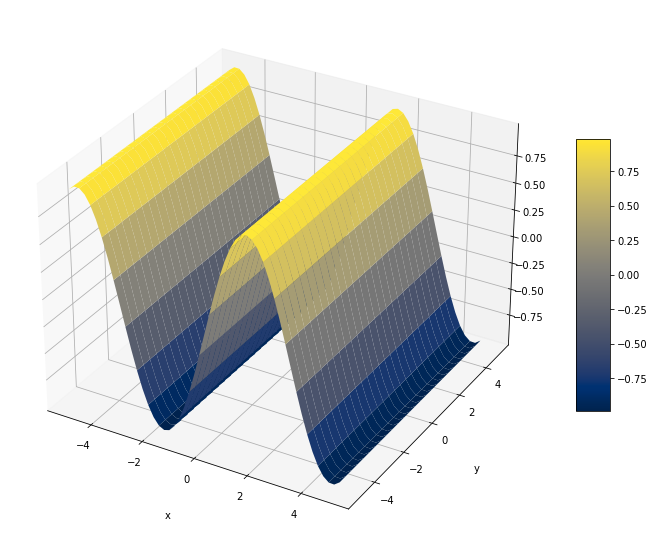

In [ ]:
# plot ribbon

plot_ribbon()

In [ ]:
def sample_ribbon(start=-5, end=5.1, increment=0.2, num_points=1000, dim=3):
    '''
    sample points uniformly from ribbon
    Inputs
    - start: starting point of sinusoidal function
    - end: ending point of sinusoidal function
    - increment: segment size between start and ed
    - num_points: number of points sampled from the sinusoidal manifold
    Outputs
    - points_mat:
    - flow_mat:
    Examples
    X = sample_ribbon()[0] # points
    X_ = sample_ribbon()[1] # flows
    '''
    # sample points
    sample_x = np.random.uniform(low=start, high=end, size = num_points)
    sample_y = np.random.uniform(low=start, high=end, size = num_points)

    points_mat = np.ndarray(shape=(num_points, dim))
    points_mat[:, 0] = sample_x
    points_mat[:, 1] = sample_y
    points_mat[:, 2] = np.sin(sample_x)

    # calculate flow: unit tangent line at each sampled point
    flow_mat = np.ndarray(shape = (num_points, dim))
    flow_mat[:, 0] = [1] * num_points
    flow_mat[:, 1] = [1] * num_points
    flow_mat[:, 2] = np.cos(sample_x)
    # row normalize
    row_sums = flow_mat.sum(axis=1)
    flow_mat = flow_mat / row_sums[:, np.newaxis]

    return points_mat, flow_mat


In [ ]:
X = sample_ribbon()[0] # points
X_ = sample_ribbon()[1] # flows

In [ ]:
def plot_ribbon_samples(points_mat, flow_mat):
    '''
    plot points sampled from the manifold with flow at each point, 
    where flow is defined as the unit tangent vector at each point
    Inputs
    - points_mat: matrix where each row is a point
    - flow_mat: matrix where each row is a derivative of each corresponding point in points_mat
    '''
    num_points, d = points_mat.shape
    fig = plt.figure(figsize = (12,10))
    ax = fig.add_subplot(projection='3d')

    # plot points
    plt.scatter(points_mat[:, 0], points_mat[:, 1], points_mat[:, 2])

    # plot flow
    mask_prob = 0 # percentage not plotted
    mask = np.random.rand(num_points) > mask_prob
    ax.quiver(points_mat[mask, 0], points_mat[mask, 1], points_mat[mask, 2], flow_mat[mask, 0], flow_mat[mask, 1], flow_mat[mask, 2], alpha=0.8, length=0.5)

    # label axis
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)

    plt.show()



/Users/joiazhang/opt/anaconda3/envs/plswork/lib/python3.10/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


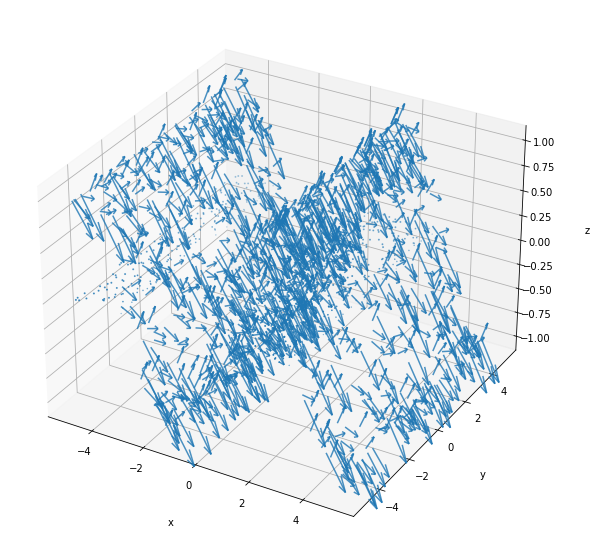

In [ ]:
plot_ribbon_samples(X, X_)

In [ ]:
X = torch.tensor(X)
X_ = torch.tensor(X_)
X = X.float().to(device)
X_ = X_.float().to(device)

In [ ]:
dfe = DiffusionFlowEmbedder(X,
X_,
t=1,
sigma_graph=15,
sigma_embedding=15,
device=device, 
autoencoder_shape = [50,10],
flow_artist_shape=[30,20,10],
flow_strength_graph=2, 
flow_strength_embedding=5, 
learnable_flow_strength=True,
weight_of_flow = 0.5,
learning_rate=0.001
)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

# Test Example 2: 2D Ribbon

In [ ]:
def sample_ribbon_2D(start=-5, end=5.1, increment=0.2, num_points=1000, dim=2):
    '''
    sample points uniformly from ribbon
    Inputs
    - start: starting point of sinusoidal function
    - end: ending point of sinusoidal function
    - increment: segment size between start and ed
    - num_points: number of points sampled from the sinusoidal manifold
    Outputs
    - points_mat:
    - flow_mat:
    Examples
    X = sample_ribbon()[0] # points
    X_ = sample_ribbon()[1] # flows
    '''
    # sample points
    sample_x = np.random.uniform(low=start, high=end, size = num_points)

    points_mat = np.ndarray(shape=(num_points, dim))
    points_mat[:, 0] = sample_x
    points_mat[:, 1] = np.sin(sample_x)

    # calculate flow: unit tangent line at each sampled point
    flow_mat = np.ndarray(shape = (num_points, dim))
    flow_mat[:, 0] = [1] * num_points
    flow_mat[:, 1] = np.cos(sample_x)
    # row normalize
    # row_sums = flow_mat.sum(axis=1)
    # flow_mat = flow_mat / row_sums[:, np.newaxis]

    return points_mat, flow_mat


In [ ]:
X2D = sample_ribbon_2D()[0] # points
X2D_ = sample_ribbon_2D()[1] # flows

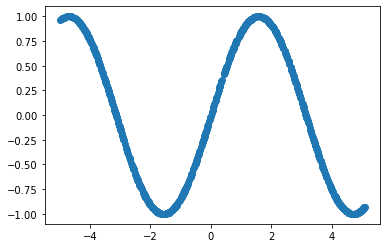

In [ ]:
plt.scatter(X2D[:, 0], X2D[:, 1])

plt.show()

In [ ]:
def plot_ribbon_samples_2D(points_mat, flow_mat):
    '''
    plot points sampled from the manifold with flow at each point, 
    where flow is defined as the unit tangent vector at each point
    Inputs
    - points_mat: matrix where each row is a point
    - flow_mat: matrix where each row is a derivative of each corresponding point in points_mat
    '''
    num_points, d = points_mat.shape
    fig = plt.figure(figsize = (12,10))
    ax = fig.add_subplot()

    # plot points
    plt.scatter(points_mat[:, 0], points_mat[:, 1])

    # plot flow
    mask_prob = 0 # percentage not plotted
    mask = np.random.rand(num_points) > mask_prob
    ax.quiver(points_mat[mask, 0], points_mat[mask, 1], flow_mat[mask, 0], flow_mat[mask, 1], alpha=0.8)

    # label axis
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)

    plt.show()



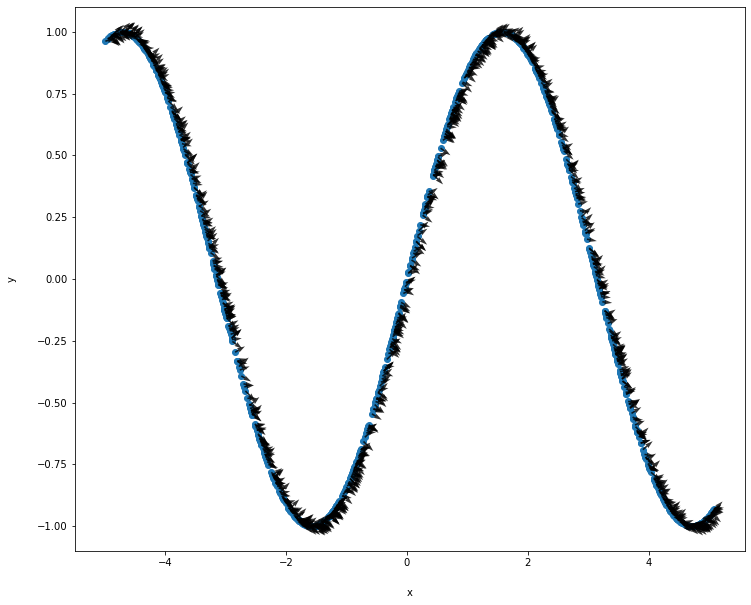

In [ ]:
plot_ribbon_samples_2D(X2D, X2D_)

# Test Example 3: 2D Moon

Using sklearn without flow

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
data = make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)

In [ ]:
points_mat = data[0]

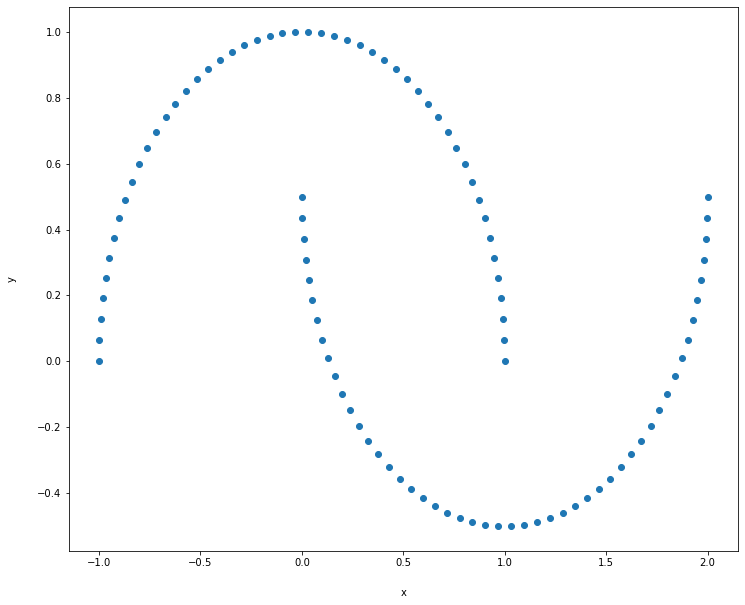

In [ ]:
num_points, d = points_mat.shape
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot()

# plot points
plt.scatter(points_mat[:, 0], points_mat[:, 1])

# plot flow
mask_prob = 0 # percentage not plotted
mask = np.random.rand(num_points) > mask_prob
# ax.quiver(points_mat[mask, 0], points_mat[mask, 1], flow_mat[mask, 0], flow_mat[mask, 1], alpha=0.8)

# label axis
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)

plt.show()

With flow

In [ ]:
def create_moons(start=-6, end=6, dim=2, num_points=100):
    halfway = int(num_points/2)
    sample_x = np.zeros(num_points)
    sample_x[0:halfway] = np.random.uniform(low=start, high=int(end/2), size = int(num_points/2))
    sample_x[halfway:num_points] = np.random.uniform(low=int(end/2), high=end, size = int(num_points/2))
    sample_x = np.random.uniform(low=start, high=end, size = num_points)
    y_noise = np.random.uniform(low=-2, high=2, size = num_points)

    points_mat = np.ndarray(shape=(num_points, dim))
    points_mat[:, 0] = sample_x
    points_mat[0:halfway, 1] = (sample_x[0:halfway]-2)**2 + y_noise[0:halfway]
    points_mat[halfway:num_points, 1] = -((sample_x[halfway:num_points])**2)+8 + y_noise[halfway:num_points]

    # calculate flow: unit tangent line at each sampled point
    flow_mat = np.ndarray(shape = (num_points, dim))
    flow_mat[:, 0] = [1] * num_points
    flow_mat[0:halfway, 1] = 2*(sample_x[0:halfway]-2)
    flow_mat[halfway:num_points, 1] = -2*(sample_x[halfway:num_points])
    return points_mat, flow_mat

In [ ]:
X, X_ = create_moons()

In [ ]:
def plot_moons(points_mat, flow_mat, mask_prob=0.4):
    '''
    Inputs
    mask_prob: percentage not plotted
    '''
    num_points, d = points_mat.shape
    fig = plt.figure(figsize = (12,10))
    ax = fig.add_subplot()

    # plot points
    plt.scatter(points_mat[:, 0], points_mat[:, 1])

    # plot flow
    mask = np.random.rand(num_points) > mask_prob
    ax.quiver(points_mat[mask, 0], points_mat[mask, 1], flow_mat[mask, 0], flow_mat[mask, 1], alpha=0.8)

    # label axis
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)

    plt.show()

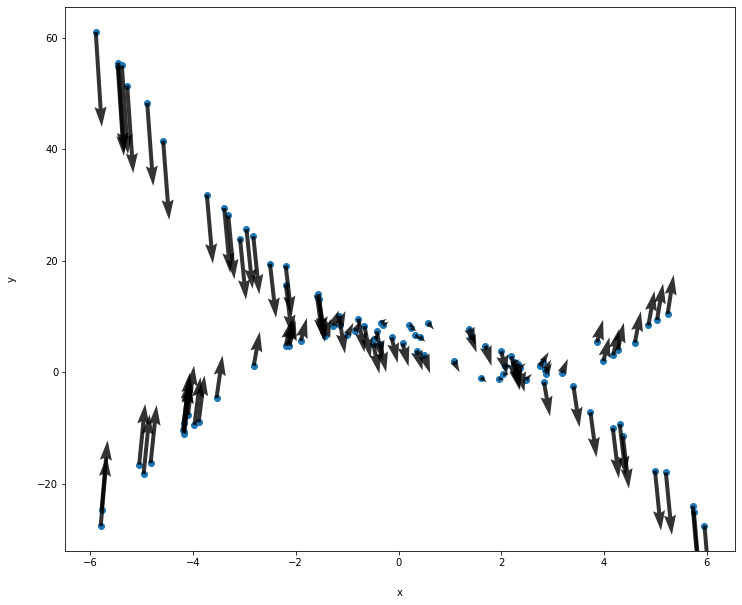

In [ ]:
plot_moons(X, X_, 0)